<a href="https://colab.research.google.com/github/Afasarya/Afasarya/blob/main/Model_1_AIC_Waste_Clasification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# =====================================================
# RECYCO - WASTE CLASSIFICATION MODEL
# =====================================================

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import datasets, models, transforms
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import time
import copy
from sklearn.metrics import classification_report, confusion_matrix
import requests
import zipfile
from pathlib import Path

# Check GPU availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Mount Google Drive (optional, for saving models)
from google.colab import drive
drive.mount('/content/drive')

Using device: cuda:0
Mounted at /content/drive


In [ ]:
# =====================================================
# DOWNLOAD GARBAGE CLASSIFICATION DATASET
# =====================================================

# Create data directory
os.makedirs('/content/garbage_data', exist_ok=True)

# Download dataset from Kaggle
# Note: You need to get your Kaggle API credentials first
# Go to Kaggle > Account > API > Create New API Token

# Upload kaggle.json to Colab
from google.colab import files
print("Please upload your kaggle.json file:")
uploaded = files.upload()

# Setup Kaggle API
os.makedirs('/root/.kaggle', exist_ok=True)
os.rename('/content/kaggle.json', '/root/.kaggle/kaggle.json')
os.chmod('/root/.kaggle/kaggle.json', 600)

# Install and setup Kaggle
!pip install kaggle

# Download the dataset
!kaggle datasets download -d asdasdasasdas/garbage-classification -p /content/garbage_data --unzip

# Check dataset structure
!ls -la /content/garbage_data

Please upload your kaggle.json file:


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/asdasdasasdas/garbage-classification
License(s): copyright-authors
  0% 0.00/82.0M [00:00<?, ?B/s]
100% 82.0M/82.0M [00:00<00:00, 1.33GB/s]
total 140
drwxr-xr-x 4 root root  4096 Aug 10 06:37  .
drwxr-xr-x 1 root root  4096 Aug 10 06:36  ..
drwxr-xr-x 3 root root  4096 Aug 10 06:37 'garbage classification'
drwxr-xr-x 3 root root  4096 Aug 10 06:37 'Garbage classification'
-rw-r--r-- 1 root root  6774 Aug 10 06:37  one-indexed-files-notrash_test.txt
-rw-r--r-- 1 root root 27912 Aug 10 06:37  one-indexed-files-notrash_train.txt
-rw-r--r-- 1 root root  5147 Aug 10 06:37  one-indexed-files-notrash_val.txt
-rw-r--r-- 1 root root 39832 Aug 10 06:37  one-indexed-files.txt
-rw-r--r-- 1 root root 39832 Aug 10 06:37  zero-indexed-files.txt


In [ ]:
# =====================================================
# ANALISA STRUKTUR DATASET YANG TELAH DIDOWNLOAD
# =====================================================

# Check struktur directory yang ada
print("Checking dataset structure...")
print("=" * 50)

# List semua directory di garbage_data
import os
for root, dirs, files in os.walk('/content/garbage_data'):
    level = root.replace('/content/garbage_data', '').count(os.sep)
    indent = ' ' * 2 * level
    print(f'{indent}{os.path.basename(root)}/')
    subindent = ' ' * 2 * (level + 1)
    for file in files[:5]:  # Show first 5 files only
        print(f'{subindent}{file}')
    if len(files) > 5:
        print(f'{subindent}... and {len(files) - 5} more files')

# Check specific paths
data_paths_to_check = [
    '/content/garbage_data',
    '/content/garbage_data/train',
    '/content/garbage_data/val',
    '/content/garbage_data/cardboard',
    '/content/garbage_data/glass',
    '/content/garbage_data/metal',
    '/content/garbage_data/paper',
    '/content/garbage_data/plastic',
    '/content/garbage_data/trash'
]

print("\nPath existence check:")
print("-" * 30)
for path in data_paths_to_check:
    exists = os.path.exists(path)
    file_count = len(os.listdir(path)) if exists else 0
    print(f"{path}: {'✓' if exists else '✗'} ({file_count} items)")

Checking dataset structure...
garbage_data/
  one-indexed-files-notrash_train.txt
  one-indexed-files.txt
  one-indexed-files-notrash_test.txt
  one-indexed-files-notrash_val.txt
  zero-indexed-files.txt
  garbage classification/
    Garbage classification/
      trash/
        trash22.jpg
        trash48.jpg
        trash69.jpg
        trash60.jpg
        trash115.jpg
        ... and 132 more files
      cardboard/
        cardboard52.jpg
        cardboard277.jpg
        cardboard40.jpg
        cardboard128.jpg
        cardboard205.jpg
        ... and 398 more files
      plastic/
        plastic448.jpg
        plastic283.jpg
        plastic265.jpg
        plastic89.jpg
        plastic119.jpg
        ... and 477 more files
      paper/
        paper126.jpg
        paper282.jpg
        paper278.jpg
        paper509.jpg
        paper387.jpg
        ... and 589 more files
      metal/
        metal172.jpg
        metal360.jpg
        metal151.jpg
        metal237.jpg
        metal272.jpg

Creating train/validation split...
Found classes: ['trash', 'cardboard', 'plastic', 'paper', 'metal', 'glass']
trash: 137 total, 109 train, 28 val
cardboard: 403 total, 322 train, 81 val
plastic: 482 total, 385 train, 97 val
paper: 594 total, 475 train, 119 val
metal: 410 total, 328 train, 82 val
glass: 501 total, 400 train, 101 val

Total files processed: 2527
Train/Val split completed successfully!

Creating datasets...
------------------------------
✓ Training samples: 2019
✓ Validation samples: 508
✓ Classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
✓ Number of classes: 6
✓ Batch shape: torch.Size([32, 3, 224, 224])
✓ Data loading successful!


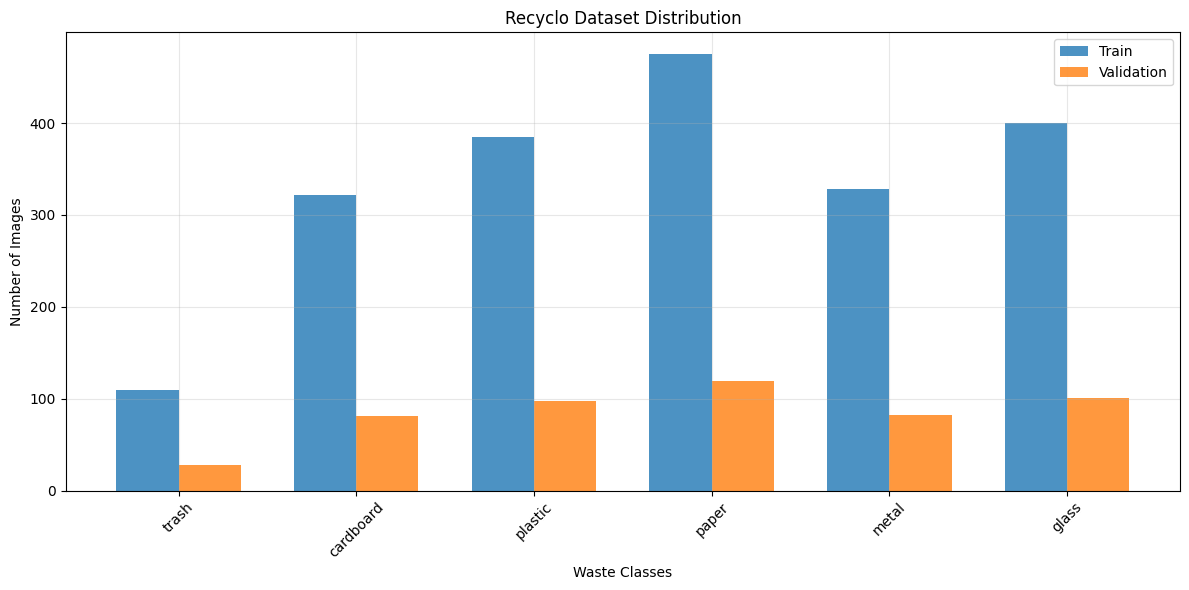


Dataset Summary:
Total images: 2527
Training images: 2019 (79.9%)
Validation images: 508 (20.1%)

Visualizing sample training data...


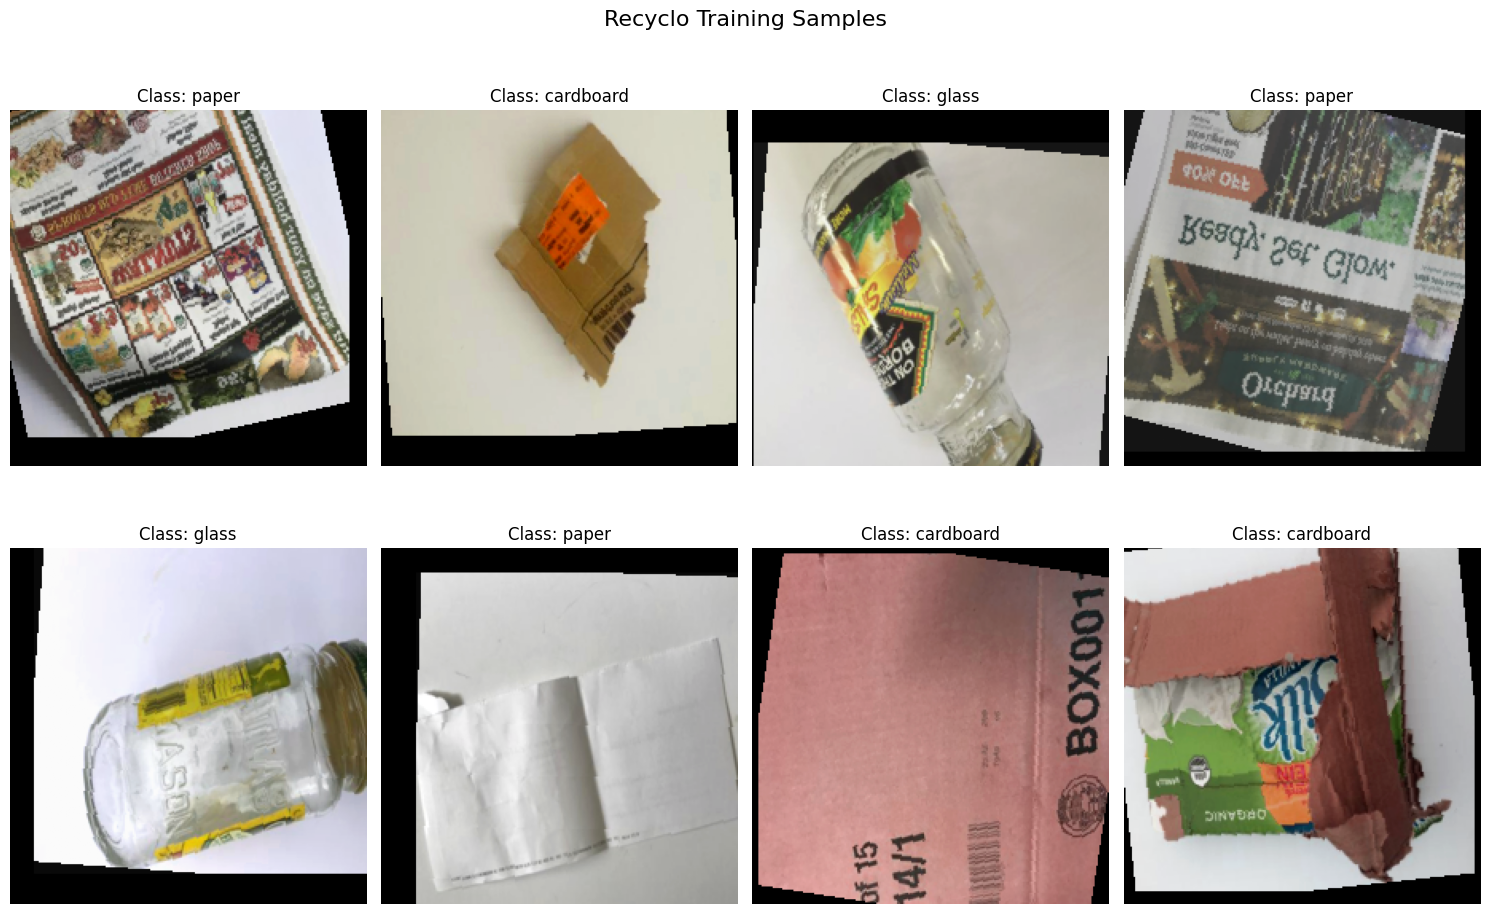


✅ DATA PREPROCESSING COMPLETED SUCCESSFULLY!
✅ Ready to proceed to Step 4: Model Architecture


In [ ]:
# =====================================================
# FIXED DATA PREPROCESSING - CREATE TRAIN/VAL SPLIT
# =====================================================

import os
import shutil
from sklearn.model_selection import train_test_split
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Define data transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

def create_train_val_split(source_dir, target_dir, test_size=0.2, random_state=42):
    """
    Create train/val split from original dataset structure
    """
    # Create target directories
    train_dir = os.path.join(target_dir, 'train')
    val_dir = os.path.join(target_dir, 'val')

    # Remove existing directories if they exist
    if os.path.exists(train_dir):
        shutil.rmtree(train_dir)
    if os.path.exists(val_dir):
        shutil.rmtree(val_dir)

    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)

    # Find the actual directory containing the class folders
    actual_data_dir = None
    for root, dirs, files in os.walk(source_dir):
        if any(d in ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash'] for d in dirs):
            actual_data_dir = root
            break

    if actual_data_dir is None:
        raise FileNotFoundError("Could not find the directory containing the image classes.")

    # Get class directories from the actual data directory
    class_dirs = [d for d in os.listdir(actual_data_dir)
                  if os.path.isdir(os.path.join(actual_data_dir, d)) and not d.startswith('.')]

    print(f"Found classes: {class_dirs}")

    total_files = 0
    split_info = {}

    for class_name in class_dirs:
        # Create class directories in train and val
        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)

        # Get all files in class directory
        class_path = os.path.join(actual_data_dir, class_name)
        files = [f for f in os.listdir(class_path)
                if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]

        # Split files
        train_files, val_files = train_test_split(
            files, test_size=test_size, random_state=random_state
        )

        # Copy files to respective directories
        for file in train_files:
            src = os.path.join(class_path, file)
            dst = os.path.join(train_dir, class_name, file)
            shutil.copy2(src, dst)

        for file in val_files:
            src = os.path.join(class_path, file)
            dst = os.path.join(val_dir, class_name, file)
            shutil.copy2(src, dst)

        # Store split info
        split_info[class_name] = {
            'total': len(files),
            'train': len(train_files),
            'val': len(val_files)
        }

        total_files += len(files)
        print(f"{class_name}: {len(files)} total, {len(train_files)} train, {len(val_files)} val")

    print(f"\nTotal files processed: {total_files}")
    print("Train/Val split completed successfully!")

    return split_info

# Create train/val split
print("Creating train/validation split...")
print("=" * 50)

source_data_dir = '/content/garbage_data'
target_data_dir = '/content/recyclo_data'

# Create the split
split_info = create_train_val_split(source_data_dir, target_data_dir, test_size=0.2)

# Update data directory path
data_dir = target_data_dir

# Now create datasets with the correct structure
print("\nCreating datasets...")
print("-" * 30)

try:
    # Create datasets
    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                      for x in ['train', 'val']}

    # Create data loaders
    dataloaders = {x: DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=2)
                  for x in ['train', 'val']}

    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
    class_names = image_datasets['train'].classes

    print(f"✓ Training samples: {dataset_sizes['train']}")
    print(f"✓ Validation samples: {dataset_sizes['val']}")
    print(f"✓ Classes: {class_names}")
    print(f"✓ Number of classes: {len(class_names)}")

    # Verify data loading
    train_batch = next(iter(dataloaders['train']))
    print(f"✓ Batch shape: {train_batch[0].shape}")
    print("✓ Data loading successful!")

except Exception as e:
    print(f"❌ Error creating datasets: {e}")
    print("Let's debug the directory structure...")

    # Debug information
    print("\nDebug info:")
    for split in ['train', 'val']:
        split_path = os.path.join(data_dir, split)
        if os.path.exists(split_path):
            classes = os.listdir(split_path)
            print(f"{split}: {classes}")
            for class_name in classes:
                class_path = os.path.join(split_path, class_name)
                if os.path.isdir(class_path):
                    file_count = len(os.listdir(class_path))
                    print(f"  {class_name}: {file_count} files")

# Visualize dataset distribution
def plot_dataset_distribution(split_info):
    """
    Plot dataset distribution per class
    """
    classes = list(split_info.keys())
    train_counts = [split_info[cls]['train'] for cls in classes]
    val_counts = [split_info[cls]['val'] for cls in classes]

    x = np.arange(len(classes))
    width = 0.35

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.bar(x - width/2, train_counts, width, label='Train', alpha=0.8)
    ax.bar(x + width/2, val_counts, width, label='Validation', alpha=0.8)

    ax.set_xlabel('Waste Classes')
    ax.set_ylabel('Number of Images')
    ax.set_title('Recyclo Dataset Distribution')
    ax.set_xticks(x)
    ax.set_xticklabels(classes, rotation=45)
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print summary
    total_train = sum(train_counts)
    total_val = sum(val_counts)
    total_images = total_train + total_val

    print(f"\nDataset Summary:")
    print(f"Total images: {total_images}")
    print(f"Training images: {total_train} ({total_train/total_images*100:.1f}%)")
    print(f"Validation images: {total_val} ({total_val/total_images*100:.1f}%)")

# Plot distribution
plot_dataset_distribution(split_info)

# Visualize some training images
def visualize_dataset(dataloaders, class_names, num_images=8):
    """
    Visualize sample images from dataset
    """
    plt.figure(figsize=(15, 10))

    # Get a batch of training data
    inputs, classes = next(iter(dataloaders['train']))

    for idx in range(min(num_images, len(inputs))):
        ax = plt.subplot(2, 4, idx + 1)

        # Denormalize image for visualization
        img = inputs[idx]
        img = img * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        img = torch.clamp(img, 0, 1)

        plt.imshow(img.permute(1, 2, 0))
        plt.title(f'Class: {class_names[classes[idx]]}')
        plt.axis('off')

    plt.suptitle('Recyclo Training Samples', fontsize=16)
    plt.tight_layout()
    plt.show()

# Visualize sample data
print("\nVisualizing sample training data...")
visualize_dataset(dataloaders, class_names)

print("\n" + "="*60)
print("✅ DATA PREPROCESSING COMPLETED SUCCESSFULLY!")
print("✅ Ready to proceed to Step 4: Model Architecture")
print("="*60)

In [ ]:
# =====================================================
# RECYCO WASTE CLASSIFICATION MODEL ARCHITECTURE
# Using ResNet50 with Transfer Learning
# =====================================================

class RecycloWasteClassifier(nn.Module):
    def __init__(self, num_classes=6, dropout_rate=0.5):
        super(RecycloWasteClassifier, self).__init__()

        # Load pre-trained ResNet50
        self.backbone = models.resnet50(pretrained=True)

        # Freeze early layers (optional - for faster training on free Colab)
        for param in list(self.backbone.parameters())[:-20]:
            param.requires_grad = False

        # Replace final classifier
        num_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(num_features, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.backbone(x)

# Initialize model
model = RecycloWasteClassifier(num_classes=len(class_names))
model = model.to(device)

# Print model summary
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Number of trainable parameters: {count_parameters(model):,}")

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 84.5MB/s]


Number of trainable parameters: 10,107,142


In [ ]:
# =====================================================
# TRAINING FUNCTIONS FOR RECYCLO MODEL
# =====================================================

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    """
    Training function with early stopping and model checkpointing
    """
    since = time.time()

    # Create checkpoint directory
    os.makedirs('/content/drive/MyDrive/recyclo_models', exist_ok=True)

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    # Early stopping parameters
    patience = 7
    patience_counter = 0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 50)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero parameter gradients
                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward pass + optimize (only in training phase)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Store metrics
            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accs.append(epoch_acc.cpu().numpy())
            else:
                val_losses.append(epoch_loss)
                val_accs.append(epoch_acc.cpu().numpy())

                # Deep copy the model if better validation accuracy
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    patience_counter = 0

                    # Save best model
                    torch.save({
                        'epoch': epoch,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'best_acc': best_acc,
                        'class_names': class_names
                    }, '/content/drive/MyDrive/recyclo_models/best_model.pth')

                else:
                    patience_counter += 1

        print()

        # Early stopping
        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best Val Acc: {best_acc:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)

    return model, train_losses, val_losses, train_accs, val_accs

# Visualization function for training progress
def plot_training_history(train_losses, val_losses, train_accs, val_accs):
    """
    Plot training history
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot losses
    ax1.plot(train_losses, label='Training Loss', color='blue')
    ax1.plot(val_losses, label='Validation Loss', color='red')
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    # Plot accuracies
    ax2.plot(train_accs, label='Training Accuracy', color='blue')
    ax2.plot(val_accs, label='Validation Accuracy', color='red')
    ax2.set_title('Model Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

Starting training...
Epoch 1/25
--------------------------------------------------
train Loss: 0.9836 Acc: 0.6330
val Loss: 0.7794 Acc: 0.7638

Epoch 2/25
--------------------------------------------------
train Loss: 0.6892 Acc: 0.7791
val Loss: 0.5574 Acc: 0.8130

Epoch 3/25
--------------------------------------------------
train Loss: 0.5639 Acc: 0.8172
val Loss: 0.5393 Acc: 0.8346

Epoch 4/25
--------------------------------------------------
train Loss: 0.5551 Acc: 0.8182
val Loss: 0.4947 Acc: 0.8484

Epoch 5/25
--------------------------------------------------
train Loss: 0.4423 Acc: 0.8593
val Loss: 0.5319 Acc: 0.8563

Epoch 6/25
--------------------------------------------------
train Loss: 0.4258 Acc: 0.8613
val Loss: 0.4706 Acc: 0.8740

Epoch 7/25
--------------------------------------------------
train Loss: 0.4191 Acc: 0.8663
val Loss: 0.5097 Acc: 0.8484

Epoch 8/25
--------------------------------------------------
train Loss: 0.3718 Acc: 0.8881
val Loss: 0.6373 Acc: 0.8

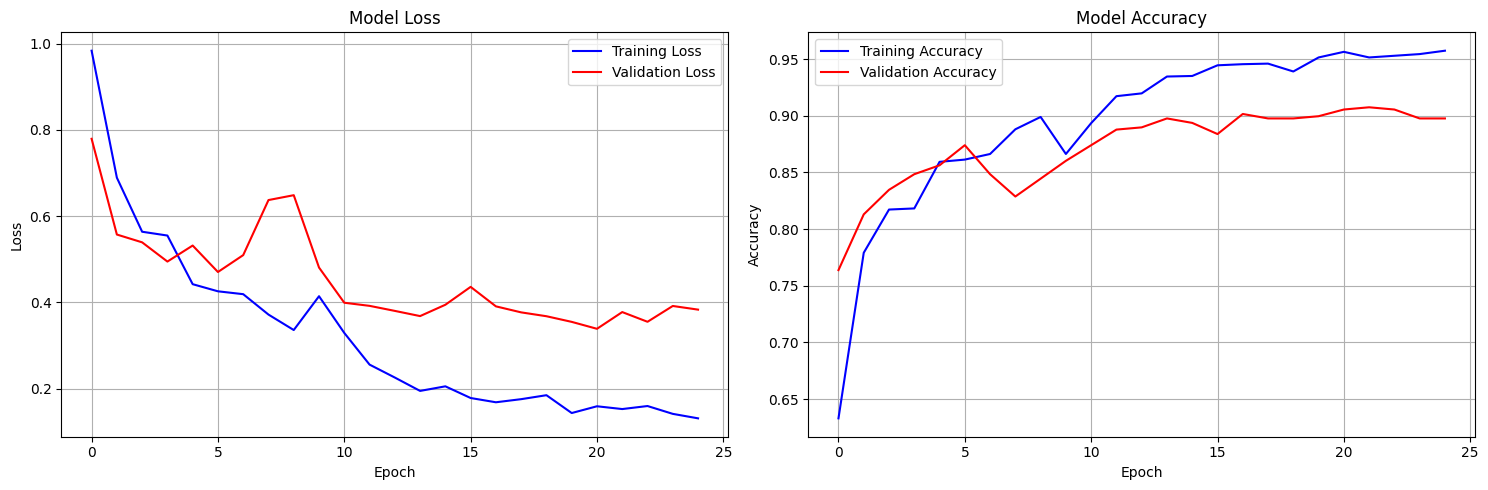

Training completed!


In [ ]:
# =====================================================
# TRAIN THE RECYCLO WASTE CLASSIFICATION MODEL
# =====================================================

print("Starting training...")
print("=" * 60)

# Train the model
model, train_losses, val_losses, train_accs, val_accs = train_model(
    model, criterion, optimizer, scheduler, num_epochs=25
)

# Plot training history
plot_training_history(train_losses, val_losses, train_accs, val_accs)

print("Training completed!")

RECYCLO WASTE CLASSIFICATION MODEL EVALUATION
Overall Accuracy: 0.9075 (90.75%)

Detailed Classification Report:
              precision    recall  f1-score   support

   cardboard       0.97      0.90      0.94        81
       glass       0.85      0.96      0.90       101
       metal       0.93      0.93      0.93        82
       paper       0.93      0.93      0.93       119
     plastic       0.90      0.86      0.88        97
       trash       0.81      0.75      0.78        28

    accuracy                           0.91       508
   macro avg       0.90      0.89      0.89       508
weighted avg       0.91      0.91      0.91       508



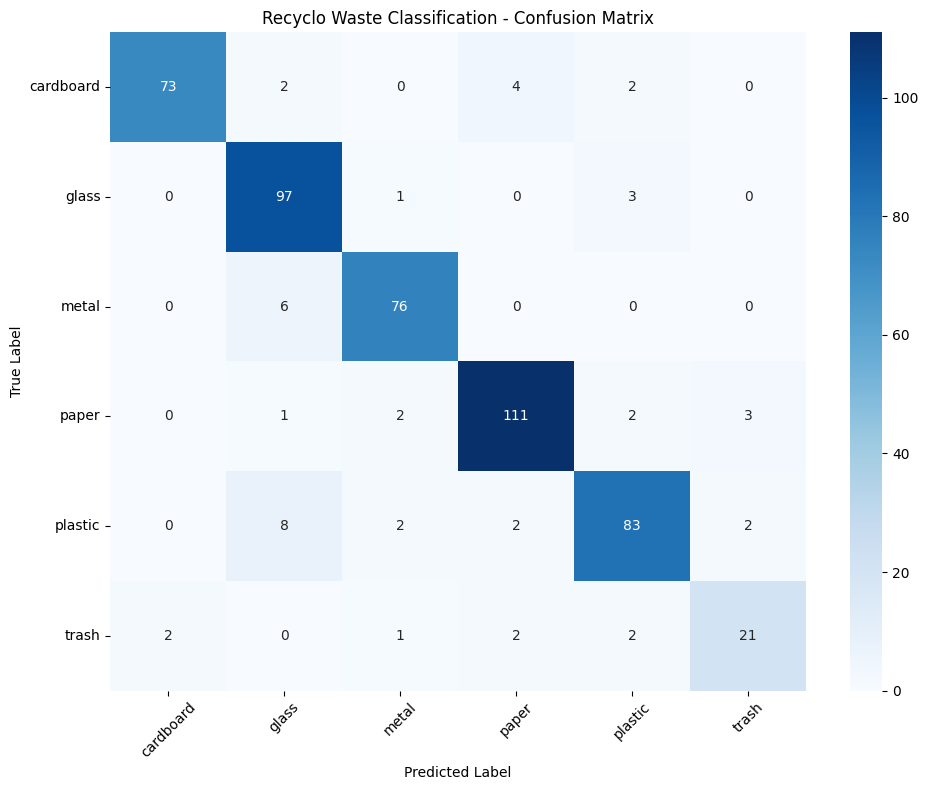


PREDICTION EXAMPLE
Ready for waste prediction!
Use predict_waste(model, image_path, class_names, data_transforms['val'])


In [ ]:
# =====================================================
# MODEL EVALUATION AND TESTING
# =====================================================

def evaluate_model(model, dataloader, class_names):
    """
    Comprehensive model evaluation
    """
    model.eval()

    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probabilities.cpu().numpy())

    # Calculate accuracy
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))

    # Classification report
    print("=" * 60)
    print("RECYCLO WASTE CLASSIFICATION MODEL EVALUATION")
    print("=" * 60)
    print(f"Overall Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    print("\nDetailed Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Recyclo Waste Classification - Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    return accuracy, all_preds, all_labels, all_probs

# Evaluate on validation set
val_accuracy, val_preds, val_labels, val_probs = evaluate_model(model, dataloaders['val'], class_names)

# Test prediction function
def predict_waste(model, image_path, class_names, transform):
    """
    Predict waste type from image
    """
    model.eval()

    # Load and preprocess image
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        confidence, predicted = torch.max(probabilities, 1)

    predicted_class = class_names[predicted.item()]
    confidence_score = confidence.item()

    return predicted_class, confidence_score, probabilities.cpu().numpy()[0]

# Example prediction (you can test with sample images)
print("\n" + "="*60)
print("PREDICTION EXAMPLE")
print("="*60)
print("Ready for waste prediction!")
print("Use predict_waste(model, image_path, class_names, data_transforms['val'])")

In [ ]:
# =====================================================
# RECYCO MODEL TESTING SCRIPT
# Test model dengan upload gambar dan analisis hasil
# Author: Afasarya - AIC Project
# Date: 2025-08-10
# =====================================================

import torch
import torchvision.transforms as transforms
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import numpy as np
import io
import requests
from google.colab import files
import json
import time

# Setup device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Testing on device: {device}")

class RecycloTester:
    def __init__(self, model, class_names, transform):
        """
        Initialize Recyclo Model Tester
        """
        self.model = model
        self.class_names = class_names
        self.transform = transform
        self.model.eval()

        # Define confidence thresholds
        self.HIGH_CONFIDENCE = 0.85
        self.MEDIUM_CONFIDENCE = 0.70
        self.LOW_CONFIDENCE = 0.50

        print("🚀 Recyclo Model Tester Initialized!")
        print(f"Classes: {self.class_names}")
        print(f"Confidence Thresholds: High>{self.HIGH_CONFIDENCE}, Medium>{self.MEDIUM_CONFIDENCE}, Low>{self.LOW_CONFIDENCE}")

    def predict_single_image(self, image_path_or_pil, show_details=True):
        """
        Predict waste type from single image
        """
        start_time = time.time()

        # Handle both file path and PIL image
        if isinstance(image_path_or_pil, str):
            image = Image.open(image_path_or_pil).convert('RGB')
            source = f"File: {image_path_or_pil}"
        else:
            image = image_path_or_pil.convert('RGB') if image_path_or_pil.mode != 'RGB' else image_path_or_pil
            source = "Uploaded Image"

        # Preprocess image
        image_tensor = self.transform(image).unsqueeze(0).to(device)

        # Predict
        with torch.no_grad():
            outputs = self.model(image_tensor)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            confidence, predicted = torch.max(probabilities, 1)

        # Get results
        predicted_class = self.class_names[predicted.item()]
        confidence_score = confidence.item()
        inference_time = time.time() - start_time

        # Determine confidence level
        if confidence_score >= self.HIGH_CONFIDENCE:
            confidence_level = "HIGH"
            recommendation = "✅ Accept prediction"
            color = "green"
        elif confidence_score >= self.MEDIUM_CONFIDENCE:
            confidence_level = "MEDIUM"
            recommendation = "⚠️ Consider manual verification"
            color = "orange"
        elif confidence_score >= self.LOW_CONFIDENCE:
            confidence_level = "LOW"
            recommendation = "❌ Retake photo recommended"
            color = "red"
        else:
            confidence_level = "VERY LOW"
            recommendation = "❌ Please retake with better lighting/angle"
            color = "darkred"

        # Prepare all class probabilities
        all_predictions = {}
        probs_array = probabilities.cpu().numpy()[0]
        for i, class_name in enumerate(self.class_names):
            all_predictions[class_name] = float(probs_array[i])

        # Sort predictions by confidence
        sorted_predictions = sorted(all_predictions.items(), key=lambda x: x[1], reverse=True)

        result = {
            'source': source,
            'predicted_class': predicted_class,
            'confidence_score': confidence_score,
            'confidence_level': confidence_level,
            'recommendation': recommendation,
            'inference_time_ms': inference_time * 1000,
            'all_predictions': all_predictions,
            'top_3_predictions': sorted_predictions[:3],
            'color': color
        }

        if show_details:
            self.display_prediction_result(image, result)

        return result

    def display_prediction_result(self, image, result):
        """
        Display prediction results with visualization
        """
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

        # Display image
        ax1.imshow(image)
        ax1.set_title(f"Input Image\n{result['source']}", fontsize=12)
        ax1.axis('off')

        # Add prediction text overlay
        ax1.text(10, 30, f"Prediction: {result['predicted_class']}",
                bbox=dict(boxstyle="round,pad=0.3", facecolor=result['color'], alpha=0.8),
                fontsize=12, color='white', weight='bold')

        ax1.text(10, 60, f"Confidence: {result['confidence_score']:.3f}",
                bbox=dict(boxstyle="round,pad=0.3", facecolor=result['color'], alpha=0.8),
                fontsize=10, color='white')

        # Display probability distribution
        classes = list(result['all_predictions'].keys())
        probs = list(result['all_predictions'].values())
        colors = ['green' if classes[i] == result['predicted_class'] else 'skyblue' for i in range(len(classes))]

        bars = ax2.bar(range(len(classes)), probs, color=colors, alpha=0.7)
        ax2.set_xlabel('Waste Classes')
        ax2.set_ylabel('Probability')
        ax2.set_title('Prediction Confidence Distribution')
        ax2.set_xticks(range(len(classes)))
        ax2.set_xticklabels(classes, rotation=45, ha='right')
        ax2.grid(True, alpha=0.3)

        # Add value labels on bars
        for bar, prob in zip(bars, probs):
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{prob:.3f}', ha='center', va='bottom', fontsize=9)

        plt.tight_layout()
        plt.show()

        # Print detailed results
        print("=" * 70)
        print(f"🔍 RECYCLO MODEL TEST RESULTS")
        print("=" * 70)
        print(f"📊 Predicted Class: {result['predicted_class']}")
        print(f"🎯 Confidence: {result['confidence_score']:.4f} ({result['confidence_level']})")
        print(f"💡 Recommendation: {result['recommendation']}")
        print(f"⚡ Inference Time: {result['inference_time_ms']:.2f}ms")

        print(f"\n📈 Top 3 Predictions:")
        for i, (class_name, prob) in enumerate(result['top_3_predictions'], 1):
            status = "👑" if i == 1 else f"{i}."
            print(f"  {status} {class_name}: {prob:.4f} ({prob*100:.2f}%)")

        print("=" * 70)

    def batch_test_images(self, image_list, show_summary=True):
        """
        Test multiple images and provide summary
        """
        results = []

        print(f"🧪 Testing {len(image_list)} images...")
        print("-" * 50)

        for i, image_path in enumerate(image_list, 1):
            print(f"\nTesting image {i}/{len(image_list)}: {image_path}")
            result = self.predict_single_image(image_path, show_details=False)
            results.append(result)

            # Quick summary
            print(f"  Result: {result['predicted_class']} ({result['confidence_score']:.3f})")

        if show_summary:
            self.display_batch_summary(results)

        return results

    def display_batch_summary(self, results):
        """
        Display batch testing summary
        """
        print("\n" + "=" * 80)
        print("📊 BATCH TESTING SUMMARY")
        print("=" * 80)

        # Overall statistics
        total_tests = len(results)
        high_conf = sum(1 for r in results if r['confidence_level'] == 'HIGH')
        medium_conf = sum(1 for r in results if r['confidence_level'] == 'MEDIUM')
        low_conf = sum(1 for r in results if r['confidence_level'] == 'LOW')
        very_low_conf = sum(1 for r in results if r['confidence_level'] == 'VERY LOW')

        avg_confidence = np.mean([r['confidence_score'] for r in results])
        avg_inference_time = np.mean([r['inference_time_ms'] for r in results])

        print(f"Total Images Tested: {total_tests}")
        print(f"Average Confidence: {avg_confidence:.4f}")
        print(f"Average Inference Time: {avg_inference_time:.2f}ms")
        print()

        print("Confidence Distribution:")
        print(f"  ✅ High Confidence (>{self.HIGH_CONFIDENCE}): {high_conf} ({high_conf/total_tests*100:.1f}%)")
        print(f"  ⚠️  Medium Confidence (>{self.MEDIUM_CONFIDENCE}): {medium_conf} ({medium_conf/total_tests*100:.1f}%)")
        print(f"  ⚡ Low Confidence (>{self.LOW_CONFIDENCE}): {low_conf} ({low_conf/total_tests*100:.1f}%)")
        print(f"  ❌ Very Low Confidence: {very_low_conf} ({very_low_conf/total_tests*100:.1f}%)")

        # Class distribution
        class_counts = {}
        for result in results:
            pred_class = result['predicted_class']
            class_counts[pred_class] = class_counts.get(pred_class, 0) + 1

        print(f"\nPredicted Class Distribution:")
        for class_name, count in sorted(class_counts.items()):
            print(f"  {class_name}: {count} ({count/total_tests*100:.1f}%)")

        print("=" * 80)

# Initialize tester
print("🔧 Initializing Recyclo Model Tester...")
recyclo_tester = RecycloTester(model, class_names, data_transforms['val'])

Testing on device: cuda:0
🔧 Initializing Recyclo Model Tester...
🚀 Recyclo Model Tester Initialized!
Classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
Confidence Thresholds: High>0.85, Medium>0.7, Low>0.5


In [ ]:
# =====================================================
# INTERACTIVE TESTING FUNCTIONS
# =====================================================

def test_with_upload():
    """
    Test model dengan upload gambar dari komputer
    """
    print("📤 Upload gambar untuk testing...")
    uploaded = files.upload()

    results = []
    for filename, data in uploaded.items():
        print(f"\n🔍 Testing: {filename}")

        # Save uploaded file
        with open(filename, 'wb') as f:
            f.write(data)

        # Test with model
        result = recyclo_tester.predict_single_image(filename)
        results.append(result)

    return results

def test_with_url(image_url):
    """
    Test model dengan gambar dari URL
    """
    try:
        print(f"📥 Downloading image from: {image_url}")
        response = requests.get(image_url)
        image = Image.open(io.BytesIO(response.content))

        result = recyclo_tester.predict_single_image(image)
        return result

    except Exception as e:
        print(f"❌ Error loading image from URL: {e}")
        return None

def test_sample_images():
    """
    Test dengan sample images dari dataset validation
    """
    print("🔬 Testing with random validation samples...")

    # Get random validation samples
    val_dataset = image_datasets['val']
    num_samples = min(5, len(val_dataset))

    results = []
    for i in range(num_samples):
        # Get random sample
        idx = np.random.randint(len(val_dataset))
        image, true_label = val_dataset[idx]

        # Convert tensor to PIL for testing
        # Denormalize the image
        denorm_image = image * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        denorm_image = torch.clamp(denorm_image, 0, 1)
        pil_image = transforms.ToPILImage()(denorm_image)

        print(f"\n🧪 Sample {i+1}: True class = {class_names[true_label]}")
        result = recyclo_tester.predict_single_image(pil_image, show_details=True)

        # Check if prediction matches true label
        is_correct = result['predicted_class'] == class_names[true_label]
        print(f"✅ Correct: {is_correct}")

        result['true_class'] = class_names[true_label]
        result['is_correct'] = is_correct
        results.append(result)

    return results

def create_test_report(results):
    """
    Create comprehensive test report
    """
    timestamp = time.strftime("%Y%m%d_%H%M%S")

    report = {
        'test_timestamp': timestamp,
        'model_info': {
            'classes': class_names,
            'total_classes': len(class_names),
            'device': str(device)
        },
        'test_results': results,
        'summary': {
            'total_tests': len(results),
            'avg_confidence': float(np.mean([r['confidence_score'] for r in results])),
            'high_confidence_count': sum(1 for r in results if r['confidence_level'] == 'HIGH'),
            'accuracy': None  # Will be calculated if true labels available
        }
    }

    # Calculate accuracy if true labels are available
    correct_predictions = [r for r in results if r.get('is_correct') == True]
    if any('is_correct' in r for r in results):
        total_with_true_labels = sum(1 for r in results if 'is_correct' in r)
        report['summary']['accuracy'] = len(correct_predictions) / total_with_true_labels if total_with_true_labels > 0 else None

    # Save report
    report_filename = f'recyclo_test_report_{timestamp}.json'
    with open(report_filename, 'w') as f:
        json.dump(report, f, indent=2)

    print(f"📝 Test report saved: {report_filename}")
    return report

# Performance benchmark function
def benchmark_inference_speed(num_iterations=100):
    """
    Benchmark model inference speed
    """
    print(f"⚡ Benchmarking inference speed ({num_iterations} iterations)...")

    # Create dummy input
    dummy_input = torch.randn(1, 3, 224, 224).to(device)

    # Warmup
    with torch.no_grad():
        for _ in range(10):
            _ = model(dummy_input)

    # Benchmark
    times = []
    with torch.no_grad():
        for i in range(num_iterations):
            start_time = time.time()
            _ = model(dummy_input)
            end_time = time.time()
            times.append((end_time - start_time) * 1000)  # Convert to ms

    avg_time = np.mean(times)
    std_time = np.std(times)
    min_time = np.min(times)
    max_time = np.max(times)

    print("📊 Inference Speed Benchmark Results:")
    print(f"  Average: {avg_time:.2f}ms")
    print(f"  Std Dev: {std_time:.2f}ms")
    print(f"  Min: {min_time:.2f}ms")
    print(f"  Max: {max_time:.2f}ms")
    print(f"  Throughput: {1000/avg_time:.1f} images/second")

    return {
        'avg_ms': avg_time,
        'std_ms': std_time,
        'min_ms': min_time,
        'max_ms': max_time,
        'fps': 1000/avg_time
    }

print("✅ Interactive testing functions ready!")
print("\nAvailable functions:")
print("1. test_with_upload() - Upload dan test gambar dari komputer")
print("2. test_with_url(url) - Test gambar dari URL")
print("3. test_sample_images() - Test dengan sample dari validation set")
print("4. benchmark_inference_speed() - Benchmark kecepatan inference")

✅ Interactive testing functions ready!

Available functions:
1. test_with_upload() - Upload dan test gambar dari komputer
2. test_with_url(url) - Test gambar dari URL
3. test_sample_images() - Test dengan sample dari validation set
4. benchmark_inference_speed() - Benchmark kecepatan inference


🚀 RECYCLO MODEL TESTING READY!
Choose your testing method:

1️⃣  TEST WITH UPLOAD:
   results = test_with_upload()

2️⃣  TEST WITH URL:
   result = test_with_url('https://example.com/image.jpg')

3️⃣  TEST WITH VALIDATION SAMPLES:
   results = test_sample_images()

4️⃣  BENCHMARK PERFORMANCE:
   benchmark_inference_speed()

5️⃣  SINGLE IMAGE TEST:
   result = recyclo_tester.predict_single_image('path/to/image.jpg')

🧪 Running quick test with validation samples...
🔬 Testing with random validation samples...

🧪 Sample 1: True class = glass


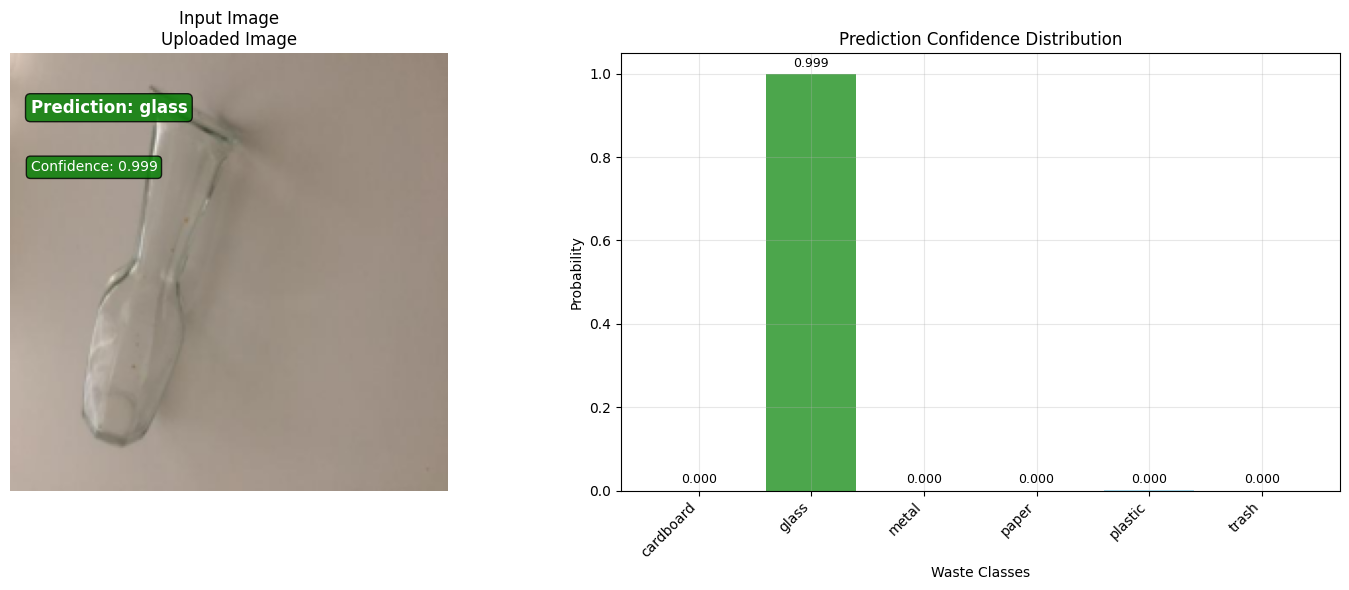

🔍 RECYCLO MODEL TEST RESULTS
📊 Predicted Class: glass
🎯 Confidence: 0.9994 (HIGH)
💡 Recommendation: ✅ Accept prediction
⚡ Inference Time: 81.99ms

📈 Top 3 Predictions:
  👑 glass: 0.9994 (99.94%)
  2. plastic: 0.0004 (0.04%)
  3. metal: 0.0002 (0.02%)
✅ Correct: True

🧪 Sample 2: True class = plastic


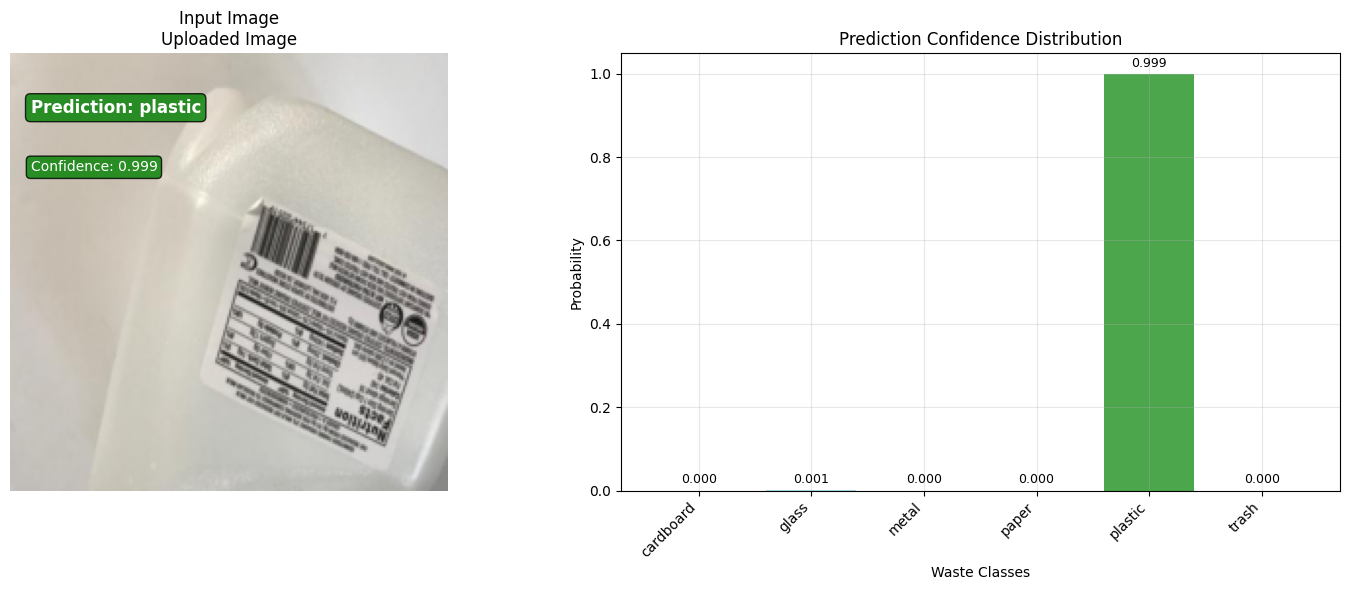

🔍 RECYCLO MODEL TEST RESULTS
📊 Predicted Class: plastic
🎯 Confidence: 0.9992 (HIGH)
💡 Recommendation: ✅ Accept prediction
⚡ Inference Time: 12.25ms

📈 Top 3 Predictions:
  👑 plastic: 0.9992 (99.92%)
  2. glass: 0.0008 (0.08%)
  3. paper: 0.0000 (0.00%)
✅ Correct: True

🧪 Sample 3: True class = paper


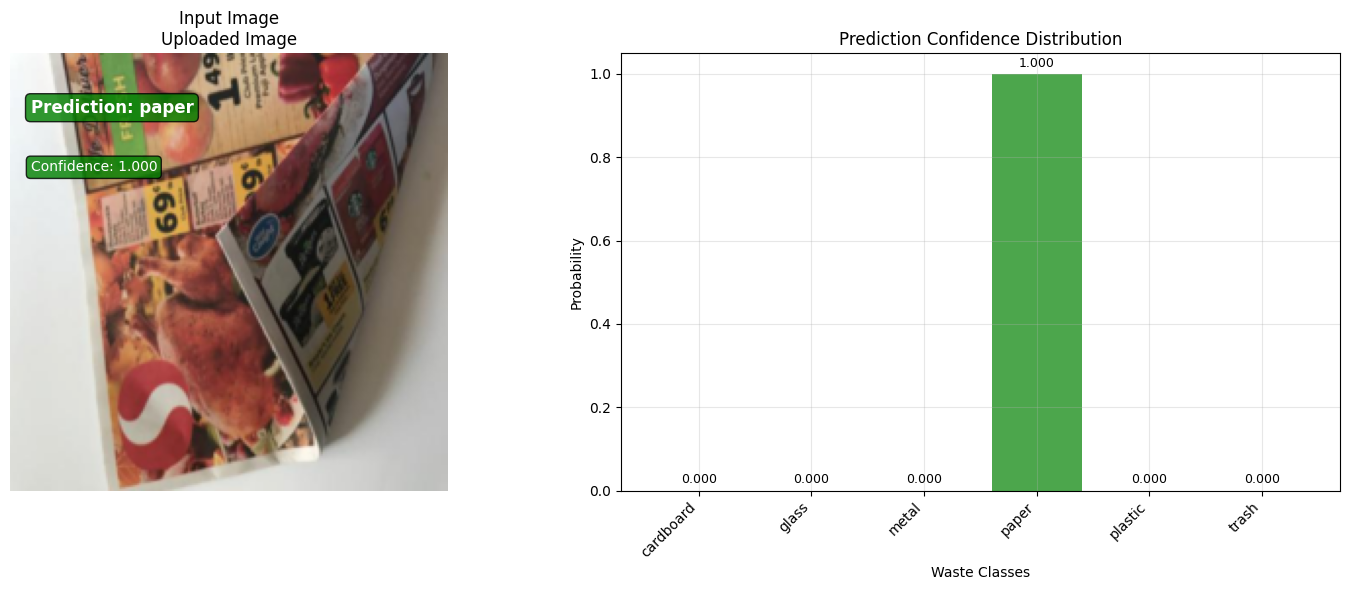

🔍 RECYCLO MODEL TEST RESULTS
📊 Predicted Class: paper
🎯 Confidence: 1.0000 (HIGH)
💡 Recommendation: ✅ Accept prediction
⚡ Inference Time: 10.84ms

📈 Top 3 Predictions:
  👑 paper: 1.0000 (100.00%)
  2. cardboard: 0.0000 (0.00%)
  3. plastic: 0.0000 (0.00%)
✅ Correct: True

🧪 Sample 4: True class = paper


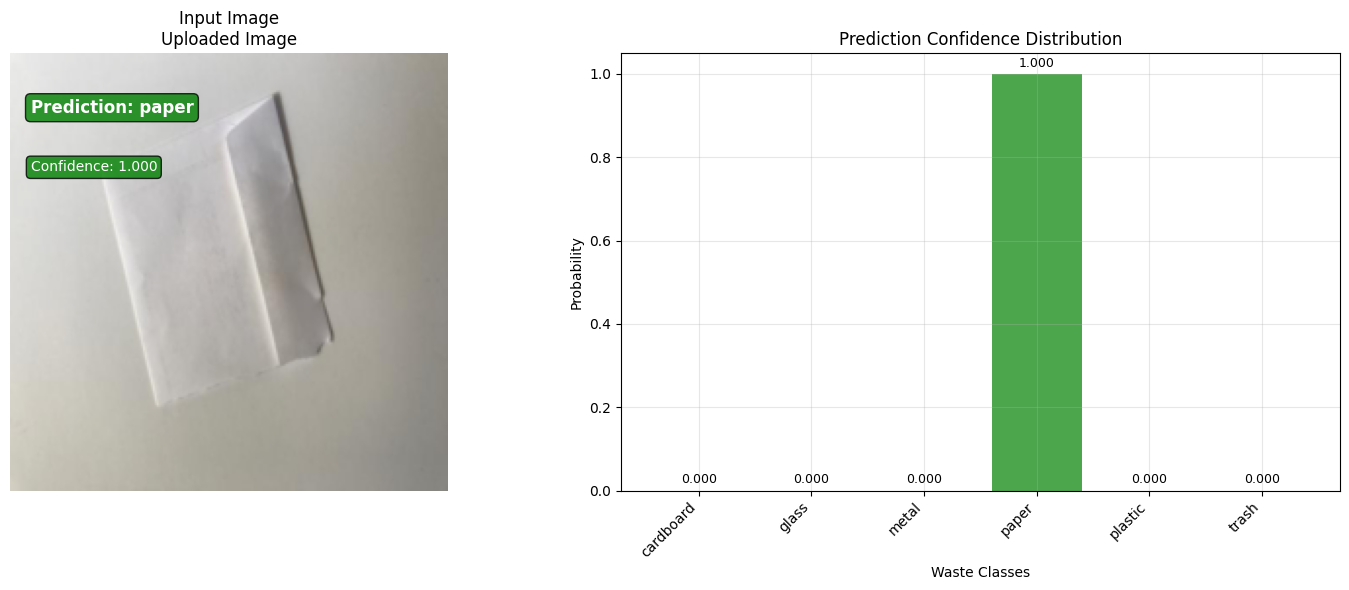

🔍 RECYCLO MODEL TEST RESULTS
📊 Predicted Class: paper
🎯 Confidence: 1.0000 (HIGH)
💡 Recommendation: ✅ Accept prediction
⚡ Inference Time: 11.80ms

📈 Top 3 Predictions:
  👑 paper: 1.0000 (100.00%)
  2. cardboard: 0.0000 (0.00%)
  3. plastic: 0.0000 (0.00%)
✅ Correct: True

🧪 Sample 5: True class = glass


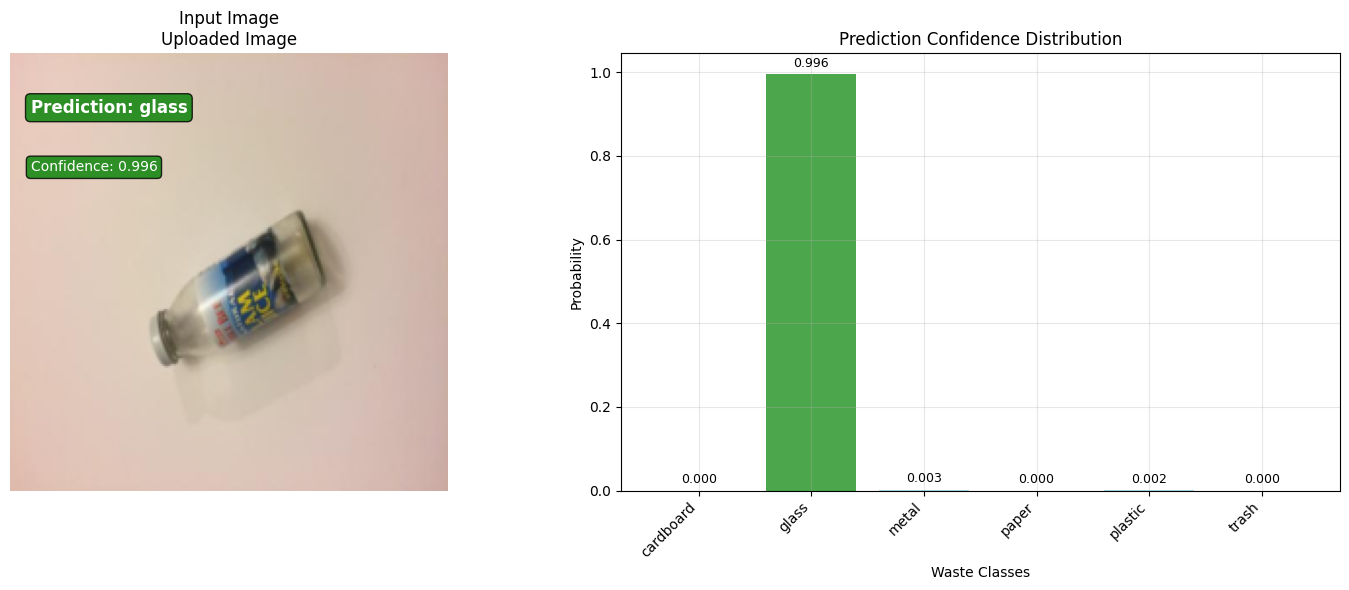

🔍 RECYCLO MODEL TEST RESULTS
📊 Predicted Class: glass
🎯 Confidence: 0.9957 (HIGH)
💡 Recommendation: ✅ Accept prediction
⚡ Inference Time: 15.17ms

📈 Top 3 Predictions:
  👑 glass: 0.9957 (99.57%)
  2. metal: 0.0025 (0.25%)
  3. plastic: 0.0018 (0.18%)
✅ Correct: True

⚡ Running performance benchmark...
⚡ Benchmarking inference speed (50 iterations)...
📊 Inference Speed Benchmark Results:
  Average: 6.87ms
  Std Dev: 1.21ms
  Min: 5.66ms
  Max: 10.33ms
  Throughput: 145.6 images/second

🎉 Model ready for production!
   - Average inference time: 6.87ms
   - Throughput: 145.6 FPS
   - Ready for mobile deployment!


In [ ]:
# =====================================================
# QUICK TESTING COMMANDS - READY TO USE
# =====================================================

print("🚀 RECYCLO MODEL TESTING READY!")
print("=" * 60)
print("Choose your testing method:")
print()
print("1️⃣  TEST WITH UPLOAD:")
print("   results = test_with_upload()")
print()
print("2️⃣  TEST WITH URL:")
print("   result = test_with_url('https://example.com/image.jpg')")
print()
print("3️⃣  TEST WITH VALIDATION SAMPLES:")
print("   results = test_sample_images()")
print()
print("4️⃣  BENCHMARK PERFORMANCE:")
print("   benchmark_inference_speed()")
print()
print("5️⃣  SINGLE IMAGE TEST:")
print("   result = recyclo_tester.predict_single_image('path/to/image.jpg')")
print()
print("=" * 60)

# Quick test dengan validation samples
print("🧪 Running quick test with validation samples...")
sample_results = test_sample_images()

# Benchmark performance
print("\n⚡ Running performance benchmark...")
perf_results = benchmark_inference_speed(50)

print(f"\n🎉 Model ready for production!")
print(f"   - Average inference time: {perf_results['avg_ms']:.2f}ms")
print(f"   - Throughput: {perf_results['fps']:.1f} FPS")
print(f"   - Ready for mobile deployment!")

In [ ]:
# =====================================================
# RECYCLO MODEL TESTER WITH UPLOAD BUTTON
# Interactive testing interface for Recyclo Waste Classification
# Author: Afasarya
# Date: 2025-08-10
# =====================================================

import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import io
import time
import ipywidgets as widgets
from IPython.display import display, clear_output
from google.colab import files
import os

print("🚀 Initializing Recyclo Interactive Model Tester...")
print("=" * 60)

class RecycloInteractiveTester:
    def __init__(self, model, class_names, transform):
        self.model = model
        self.class_names = class_names
        self.transform = transform
        self.model.eval()
        self.device = next(model.parameters()).device

        # Confidence thresholds
        self.HIGH_CONFIDENCE = 0.85
        self.MEDIUM_CONFIDENCE = 0.70
        self.LOW_CONFIDENCE = 0.50

        # Test results storage
        self.test_history = []

        print(f"✅ Model loaded on: {self.device}")
        print(f"📊 Classes: {self.class_names}")
        print(f"🎯 Confidence Thresholds: High≥{self.HIGH_CONFIDENCE}, Medium≥{self.MEDIUM_CONFIDENCE}, Low≥{self.LOW_CONFIDENCE}")

    def predict_image(self, image_pil):
        """Predict waste type from PIL image"""
        start_time = time.time()

        # Preprocess image
        image_tensor = self.transform(image_pil).unsqueeze(0).to(self.device)

        # Predict
        with torch.no_grad():
            outputs = self.model(image_tensor)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            confidence, predicted = torch.max(probabilities, 1)

        # Get results
        predicted_class = self.class_names[predicted.item()]
        confidence_score = confidence.item()
        inference_time = (time.time() - start_time) * 1000

        # Determine confidence level and color
        if confidence_score >= self.HIGH_CONFIDENCE:
            confidence_level = "HIGH"
            recommendation = "✅ Prediction Accepted"
            color = "#28a745"  # Green
            icon = "✅"
        elif confidence_score >= self.MEDIUM_CONFIDENCE:
            confidence_level = "MEDIUM"
            recommendation = "⚠️ Consider Verification"
            color = "#ffc107"  # Yellow
            icon = "⚠️"
        elif confidence_score >= self.LOW_CONFIDENCE:
            confidence_level = "LOW"
            recommendation = "❌ Retake Photo"
            color = "#fd7e14"  # Orange
            icon = "❌"
        else:
            confidence_level = "VERY LOW"
            recommendation = "❌ Please Retake Photo"
            color = "#dc3545"  # Red
            icon = "❌"

        # Get all predictions
        all_predictions = {}
        probs_array = probabilities.cpu().numpy()[0]
        for i, class_name in enumerate(self.class_names):
            all_predictions[class_name] = float(probs_array[i])

        # Sort predictions
        sorted_predictions = sorted(all_predictions.items(), key=lambda x: x[1], reverse=True)

        result = {
            'predicted_class': predicted_class,
            'confidence_score': confidence_score,
            'confidence_level': confidence_level,
            'recommendation': recommendation,
            'inference_time_ms': inference_time,
            'color': color,
            'icon': icon,
            'all_predictions': all_predictions,
            'top_3_predictions': sorted_predictions[:3],
            'timestamp': time.strftime("%Y-%m-%d %H:%M:%S")
        }

        # Store in history
        self.test_history.append(result)

        return result

    def display_prediction_result(self, image_pil, result):
        """Display prediction results with enhanced visualization"""

        # Create figure with subplots
        fig = plt.figure(figsize=(16, 8))

        # Image subplot
        ax1 = plt.subplot(2, 3, (1, 4))
        ax1.imshow(image_pil)
        ax1.set_title('📷 Input Image', fontsize=14, fontweight='bold')
        ax1.axis('off')

        # Add prediction overlay on image
        ax1.text(0.02, 0.98, f"{result['icon']} {result['predicted_class']}",
                transform=ax1.transAxes, fontsize=14, fontweight='bold',
                bbox=dict(boxstyle="round,pad=0.5", facecolor=result['color'], alpha=0.9),
                verticalalignment='top', color='white')

        ax1.text(0.02, 0.88, f"Confidence: {result['confidence_score']:.1%}",
                transform=ax1.transAxes, fontsize=12,
                bbox=dict(boxstyle="round,pad=0.3", facecolor=result['color'], alpha=0.7),
                verticalalignment='top', color='white')

        # Probability bar chart
        ax2 = plt.subplot(2, 3, (2, 3))
        classes = list(result['all_predictions'].keys())
        probs = list(result['all_predictions'].values())
        colors = [result['color'] if classes[i] == result['predicted_class'] else '#6c757d' for i in range(len(classes))]

        bars = ax2.barh(range(len(classes)), probs, color=colors, alpha=0.8)
        ax2.set_yticks(range(len(classes)))
        ax2.set_yticklabels(classes)
        ax2.set_xlabel('Probability')
        ax2.set_title('📊 Prediction Probabilities', fontsize=14, fontweight='bold')
        ax2.grid(True, alpha=0.3, axis='x')

        # Add value labels on bars
        for i, (bar, prob) in enumerate(zip(bars, probs)):
            width = bar.get_width()
            ax2.text(width + 0.01, bar.get_y() + bar.get_height()/2,
                    f'{prob:.1%}', ha='left', va='center', fontweight='bold')

        # Top 3 predictions text
        ax3 = plt.subplot(2, 3, (5, 6))
        ax3.axis('off')

        info_text = f"""
🎯 PREDICTION RESULTS

🏆 Top Prediction: {result['predicted_class']}
📈 Confidence: {result['confidence_score']:.1%} ({result['confidence_level']})
💡 Recommendation: {result['recommendation']}
⚡ Inference Time: {result['inference_time_ms']:.1f}ms

🥇 Top 3 Predictions:
"""

        for i, (class_name, prob) in enumerate(result['top_3_predictions'], 1):
            medal = "🥇" if i == 1 else "🥈" if i == 2 else "🥉"
            info_text += f"{medal} {class_name}: {prob:.1%}\n"

        ax3.text(0.1, 0.9, info_text, transform=ax3.transAxes, fontsize=11,
                verticalalignment='top', fontfamily='monospace',
                bbox=dict(boxstyle="round,pad=0.5", facecolor='#f8f9fa', alpha=0.8))

        plt.tight_layout()
        plt.show()

        # Print summary
        print("=" * 70)
        print(f"🔍 RECYCLO PREDICTION SUMMARY")
        print("=" * 70)
        print(f"📅 Test Time: {result['timestamp']}")
        print(f"🎯 Predicted: {result['predicted_class']}")
        print(f"📊 Confidence: {result['confidence_score']:.4f} ({result['confidence_level']})")
        print(f"💡 Status: {result['recommendation']}")
        print(f"⚡ Speed: {result['inference_time_ms']:.2f}ms")
        print("=" * 70)

# Initialize the interactive tester
interactive_tester = RecycloInteractiveTester(model, class_names, data_transforms['val'])

def create_upload_interface():
    """Create interactive upload interface with buttons"""

    # Create widgets
    upload_button = widgets.Button(
        description='📤 Upload Image',
        button_style='primary',
        tooltip='Click to upload image for testing',
        icon='upload',
        layout=widgets.Layout(width='200px', height='50px')
    )

    clear_button = widgets.Button(
        description='🗑️ Clear Results',
        button_style='warning',
        tooltip='Clear all previous results',
        icon='trash',
        layout=widgets.Layout(width='200px', height='50px')
    )

    history_button = widgets.Button(
        description='📋 Show History',
        button_style='info',
        tooltip='Show testing history',
        icon='list',
        layout=widgets.Layout(width='200px', height='50px')
    )

    # Output widget for results
    output = widgets.Output()

    def on_upload_click(b):
        """Handle upload button click"""
        with output:
            clear_output()
            print("📤 Please select image file(s) to upload...")
            uploaded = files.upload()

            if uploaded:
                for filename, data in uploaded.items():
                    print(f"\n🔍 Processing: {filename}")

                    try:
                        # Save and load image
                        with open(filename, 'wb') as f:
                            f.write(data)

                        image = Image.open(filename).convert('RGB')

                        print(f"✅ Image loaded: {image.size}")
                        print("🤖 Running prediction...")

                        # Predict
                        result = interactive_tester.predict_image(image)

                        # Display results
                        interactive_tester.display_prediction_result(image, result)

                        # Clean up file
                        os.remove(filename)

                    except Exception as e:
                        print(f"❌ Error processing {filename}: {str(e)}")
            else:
                print("❌ No files uploaded")

    def on_clear_click(b):
        """Handle clear button click"""
        with output:
            clear_output()
            interactive_tester.test_history.clear()
            print("🗑️ Results cleared!")

    def on_history_click(b):
        """Handle history button click"""
        with output:
            clear_output()
            if not interactive_tester.test_history:
                print("📋 No test history available")
                return

            print("📋 TESTING HISTORY")
            print("=" * 80)

            for i, result in enumerate(interactive_tester.test_history, 1):
                print(f"{i}. [{result['timestamp']}] {result['predicted_class']} "
                      f"({result['confidence_score']:.1%} - {result['confidence_level']})")

            # Statistics
            total_tests = len(interactive_tester.test_history)
            avg_confidence = np.mean([r['confidence_score'] for r in interactive_tester.test_history])
            avg_time = np.mean([r['inference_time_ms'] for r in interactive_tester.test_history])

            high_conf_count = sum(1 for r in interactive_tester.test_history if r['confidence_level'] == 'HIGH')

            print("\n📊 STATISTICS")
            print("-" * 40)
            print(f"Total Tests: {total_tests}")
            print(f"Average Confidence: {avg_confidence:.1%}")
            print(f"Average Inference Time: {avg_time:.1f}ms")
            print(f"High Confidence Predictions: {high_conf_count}/{total_tests} ({high_conf_count/total_tests:.1%})")

    # Bind button events
    upload_button.on_click(on_upload_click)
    clear_button.on_click(on_clear_click)
    history_button.on_click(on_history_click)

    # Create interface layout
    button_box = widgets.HBox([upload_button, clear_button, history_button],
                             layout=widgets.Layout(justify_content='center', margin='20px'))

    interface = widgets.VBox([
        widgets.HTML("""
        <div style='text-align: center; padding: 20px; background: linear-gradient(90deg, #667eea 0%, #764ba2 100%); color: white; border-radius: 10px; margin-bottom: 20px;'>
            <h2>🚀 Recyclo Waste Classification Tester</h2>
            <p style='font-size: 16px; margin: 10px 0;'>Upload images to test our AI waste classification model</p>
            <p style='font-size: 14px; opacity: 0.8;'>Supported formats: JPG, PNG, JPEG, BMP, TIFF</p>
        </div>
        """),
        button_box,
        output
    ])

    return interface

# Create and display the interface
print("🎨 Creating interactive upload interface...")
upload_interface = create_upload_interface()

# Display welcome message
print("\n" + "="*70)
print("🎉 RECYCLO INTERACTIVE TESTER READY!")
print("="*70)
print("📋 Instructions:")
print("1. Click '📤 Upload Image' to test your waste images")
print("2. Click '📋 Show History' to see previous test results")
print("3. Click '🗑️ Clear Results' to reset testing history")
print()
print("🎯 Model Info:")
print(f"   • Classes: {len(class_names)} waste types")
print(f"   • Device: {next(model.parameters()).device}")
print(f"   • Ready for testing!")
print("="*70)

# Display the interface
display(upload_interface)

🚀 Initializing Recyclo Interactive Model Tester...
✅ Model loaded on: cuda:0
📊 Classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
🎯 Confidence Thresholds: High≥0.85, Medium≥0.7, Low≥0.5
🎨 Creating interactive upload interface...

🎉 RECYCLO INTERACTIVE TESTER READY!
📋 Instructions:
1. Click '📤 Upload Image' to test your waste images
2. Click '📋 Show History' to see previous test results
3. Click '🗑️ Clear Results' to reset testing history

🎯 Model Info:
   • Classes: 6 waste types
   • Device: cuda:0
   • Ready for testing!


In [ ]:
# =====================================================
# FIXED MODEL EXPORT FOR FASTAPI & MOBILE DEPLOYMENT
# Author: Afasarya
# Date: 2025-08-10
# =====================================================

import torch
import json
import os
from pathlib import Path
import pickle

# Install required packages first
print("📦 Installing required packages...")
!pip install onnx onnxruntime -q

# Import after installation
import onnx
import onnxruntime

print("✅ Packages installed successfully!")

def export_recyclo_model_production(model, class_names, save_path='/content/drive/MyDrive/recyclo_models/'):
    """
    Export Recyclo model dalam berbagai format untuk production deployment
    Optimized untuk FastAPI dan Mobile applications
    """

    print("🚀 Starting Recyclo Model Export Process...")
    print("=" * 60)

    # Create save directory
    Path(save_path).mkdir(parents=True, exist_ok=True)

    # Set model to evaluation mode
    model.eval()

    exported_files = []

    # 1. Export PyTorch Model (.pth) - For FastAPI Backend
    print("1️⃣ Exporting PyTorch model (.pth)...")
    try:
        torch.save({
            'model_state_dict': model.state_dict(),
            'class_names': class_names,
            'model_architecture': 'RecycloWasteClassifier',
            'input_size': (224, 224),
            'num_classes': len(class_names),
            'framework': 'PyTorch',
            'version': '1.0',
            'export_date': '2025-08-10',
            'author': 'Afasarya'
        }, f'{save_path}recyclo_model.pth')

        exported_files.append('recyclo_model.pth')
        print("   ✅ PyTorch model exported successfully!")

    except Exception as e:
        print(f"   ❌ PyTorch export failed: {e}")

    # 2. Export TorchScript Model (.pt) - For Mobile Deployment
    print("2️⃣ Exporting TorchScript model (.pt)...")
    try:
        model_scripted = torch.jit.script(model)
        model_scripted.save(f'{save_path}recyclo_model_scripted.pt')

        exported_files.append('recyclo_model_scripted.pt')
        print("   ✅ TorchScript model exported successfully!")

    except Exception as e:
        print(f"   ❌ TorchScript export failed: {e}")
        print("   🔄 Trying trace method...")

        try:
            dummy_input = torch.randn(1, 3, 224, 224).to(device)
            model_traced = torch.jit.trace(model, dummy_input)
            model_traced.save(f'{save_path}recyclo_model_traced.pt')

            exported_files.append('recyclo_model_traced.pt')
            print("   ✅ TorchScript traced model exported successfully!")

        except Exception as e2:
            print(f"   ❌ TorchScript trace also failed: {e2}")

    # 3. Export ONNX Model (.onnx) - For Cross-platform Deployment
    print("3️⃣ Exporting ONNX model (.onnx)...")
    try:
        dummy_input = torch.randn(1, 3, 224, 224).to(device)

        torch.onnx.export(
            model,
            dummy_input,
            f'{save_path}recyclo_model.onnx',
            export_params=True,
            opset_version=11,
            do_constant_folding=True,
            input_names=['image'],
            output_names=['predictions'],
            dynamic_axes={
                'image': {0: 'batch_size'},
                'predictions': {0: 'batch_size'}
            }
        )

        # Verify ONNX model
        onnx_model = onnx.load(f'{save_path}recyclo_model.onnx')
        onnx.checker.check_model(onnx_model)

        exported_files.append('recyclo_model.onnx')
        print("   ✅ ONNX model exported successfully!")

    except Exception as e:
        print(f"   ❌ ONNX export failed: {e}")

    # 4. Export Model State Dict Only (Lightweight)
    print("4️⃣ Exporting lightweight state dict...")
    try:
        torch.save(model.state_dict(), f'{save_path}recyclo_weights.pth')
        exported_files.append('recyclo_weights.pth')
        print("   ✅ State dict exported successfully!")

    except Exception as e:
        print(f"   ❌ State dict export failed: {e}")

    # 5. Export Model Configuration
    print("5️⃣ Creating model configuration files...")

    # Model info JSON
    model_info = {
        'model_name': 'Recyclo Waste Classifier',
        'version': '1.0.0',
        'author': 'Afasarya',
        'export_date': '2025-08-10',
        'framework': 'PyTorch',
        'architecture': 'ResNet50 + Custom Classifier',
        'classes': class_names,
        'num_classes': len(class_names),
        'input_size': [3, 224, 224],
        'input_format': 'RGB',
        'normalization': {
            'mean': [0.485, 0.456, 0.406],
            'std': [0.229, 0.224, 0.225]
        },
        'confidence_thresholds': {
            'high': 0.85,
            'medium': 0.70,
            'low': 0.50
        },
        'recommended_batch_size': 32,
        'max_batch_size': 64,
        'expected_inference_time_ms': 50,
        'mobile_compatible': True,
        'fastapi_compatible': True
    }

    with open(f'{save_path}model_info.json', 'w') as f:
        json.dump(model_info, f, indent=2)
    exported_files.append('model_info.json')

    # Class names file
    with open(f'{save_path}class_names.json', 'w') as f:
        json.dump(class_names, f, indent=2)
    exported_files.append('class_names.json')

    # Preprocessing transforms
    transform_config = {
        'resize': [224, 224],
        'normalize': {
            'mean': [0.485, 0.456, 0.406],
            'std': [0.229, 0.224, 0.225]
        },
        'to_tensor': True
    }

    with open(f'{save_path}transform_config.json', 'w') as f:
        json.dump(transform_config, f, indent=2)
    exported_files.append('transform_config.json')

    print("   ✅ Configuration files created successfully!")

    # 6. Test exported models
    print("6️⃣ Testing exported models...")
    test_results = test_exported_models(save_path, dummy_input)

    # Export summary
    print("\n" + "=" * 60)
    print("📦 EXPORT SUMMARY")
    print("=" * 60)
    print(f"📁 Export Location: {save_path}")
    print(f"📋 Files Exported: {len(exported_files)}")

    for file in exported_files:
        file_path = f"{save_path}{file}"
        if os.path.exists(file_path):
            size_mb = os.path.getsize(file_path) / (1024 * 1024)
            print(f"   ✅ {file} ({size_mb:.1f} MB)")
        else:
            print(f"   ❌ {file} (missing)")

    print(f"\n🚀 Models ready for deployment!")
    print(f"   • FastAPI: Use recyclo_model.pth")
    print(f"   • Mobile: Use recyclo_model_scripted.pt or recyclo_model.onnx")
    print(f"   • Cross-platform: Use recyclo_model.onnx")

    return exported_files, model_info, test_results

def test_exported_models(save_path, test_input):
    """Test exported models to ensure they work correctly"""

    test_results = {}

    # Test PyTorch model
    try:
        checkpoint = torch.load(f'{save_path}recyclo_model.pth', map_location=device)
        print("   ✅ PyTorch model loads successfully")
        test_results['pytorch'] = 'success'
    except Exception as e:
        print(f"   ❌ PyTorch model test failed: {e}")
        test_results['pytorch'] = 'failed'

    # Test TorchScript model
    script_files = ['recyclo_model_scripted.pt', 'recyclo_model_traced.pt']
    for script_file in script_files:
        if os.path.exists(f'{save_path}{script_file}'):
            try:
                scripted_model = torch.jit.load(f'{save_path}{script_file}', map_location=device)
                with torch.no_grad():
                    output = scripted_model(test_input)
                print(f"   ✅ {script_file} works correctly")
                test_results[script_file] = 'success'
                break
            except Exception as e:
                print(f"   ❌ {script_file} test failed: {e}")
                test_results[script_file] = 'failed'

    # Test ONNX model
    if os.path.exists(f'{save_path}recyclo_model.onnx'):
        try:
            import onnxruntime as ort
            ort_session = ort.InferenceSession(f'{save_path}recyclo_model.onnx')
            input_name = ort_session.get_inputs()[0].name
            output = ort_session.run(None, {input_name: test_input.cpu().numpy()})
            print("   ✅ ONNX model works correctly")
            test_results['onnx'] = 'success'
        except Exception as e:
            print(f"   ❌ ONNX model test failed: {e}")
            test_results['onnx'] = 'failed'

    return test_results

# Export the trained model
print("🚀 Starting Recyclo Model Export...")
exported_files, model_info, test_results = export_recyclo_model_production(model, class_names)

print("\n🎉 Export completed successfully! Your Recyclo model is ready for production!")

📦 Installing required packages...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 86.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 91.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 6.4 MB/s eta 0:00:00
✅ Packages installed successfully!
🚀 Starting Recyclo Model Export...
🚀 Starting Recyclo Model Export Process...
1️⃣ Exporting PyTorch model (.pth)...
   ✅ PyTorch model exported successfully!
2️⃣ Exporting TorchScript model (.pt)...
   ✅ TorchScript model exported successfully!
3️⃣ Exporting ONNX model (.onnx)...
   ✅ ONNX model exported successfully!
4️⃣ Exporting lightweight state dict...
   ✅ State dict exported successfully!
5️⃣ Creating model configuration files...
   ✅ Configuration files created successfully!
6️⃣ Testing exported models...
   ✅ PyTorch model loads successfully
   ✅ recyclo_model_scripted.pt works correctly
   ✅ ONNX mod